# Autoregressive Integrated Moving Average (ARIMA)
Exemplo de previsão da produção de leite utilizando o dataset que acompanha o RapidMiner.
Na implementação statsmodels do modelo SARIMAX, os parâmetros são uma extensão do ARIMA, incluindo componentes adicionais para lidar com sazonalidade e variáveis externas.
A estrutura dos parâmetros é representada como (p, d, q) para a parte não sazonal e (P, D, Q, s) para a parte sazonal.

Author: RHP  
Date: 2025/Fev/24  






In [18]:
import pandas as pd

In [19]:
# Utilizar este conversor do link de partilha para um link de download: https://sites.google.com/site/gdocs2direct/
series = pd.read_csv('https://drive.google.com/uc?export=download&id=1bm3Ewl_VUlrFzLbpze8SUbm0U1CIjtdY',sep=';', header=0)
series

,Monthly milk production / pounds per cow,Date
0,589,1961-12-31 23:00:00
1,561,1962-01-31 23:00:00
2,640,1962-02-28 23:00:00
3,656,1962-04-01 00:00:00
4,727,1962-05-01 00:00:00
...,...,...
163,858,1975-08-01 00:00:00
164,817,1975-09-01 00:00:00
165,827,1975-10-01 00:00:00
166,797,1975-10-31 23:00:00


In [21]:
series['DtPeriod']=series.loc[:,'Date']
series.set_index("DtPeriod", inplace=True)
series.index=pd.period_range('1961-12', '1975-11', freq='M')
series

,Monthly milk production / pounds per cow,Date
1961-12,589,1961-12-31 23:00:00
1962-01,561,1962-01-31 23:00:00
1962-02,640,1962-02-28 23:00:00
1962-03,656,1962-04-01 00:00:00
1962-04,727,1962-05-01 00:00:00
...,...,...
1975-07,858,1975-08-01 00:00:00
1975-08,817,1975-09-01 00:00:00
1975-09,827,1975-10-01 00:00:00
1975-10,797,1975-10-31 23:00:00


In [10]:
# Decomposição da série temporal na Tendência, Sasonalidade e Residual
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
from statsmodels.tsa.seasonal import seasonal_decompose
dftemp=series[['Date','Monthly milk production / pounds per cow']].copy()
dftemp.set_index("Date", inplace=True)
decomp=seasonal_decompose(dftemp, model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)

pd_trend=pd.DataFrame(decomp.trend.array, index=decomp.trend.index,columns=['Trend'])
pd_seasonal=pd.DataFrame(decomp.seasonal.array, index=decomp.trend.index,columns=['Seasonal'])
pd_resid=pd.DataFrame(decomp.resid.array, index=decomp.resid.index,columns=['Resid'])

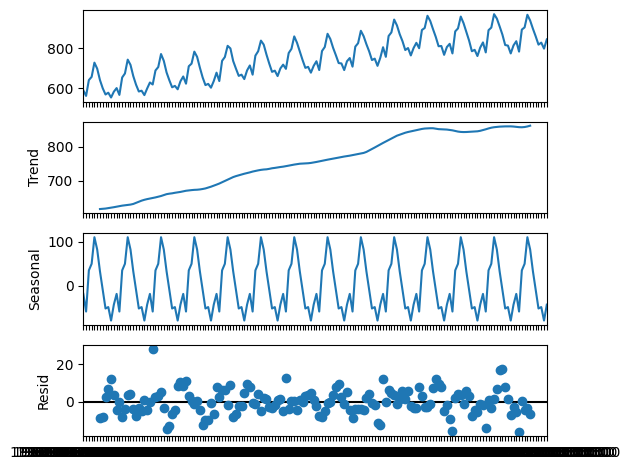

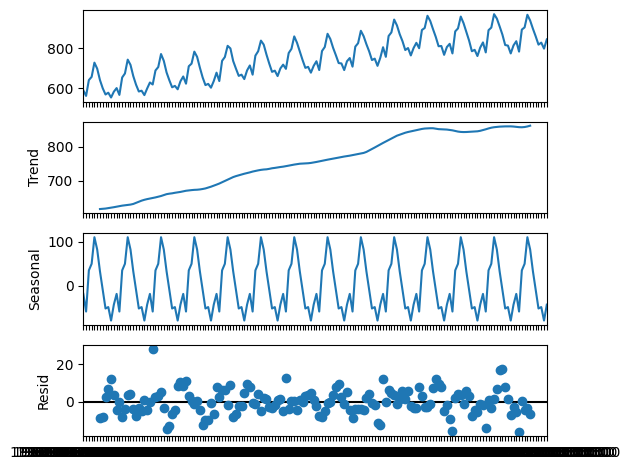

In [7]:
decomp.plot()


In [11]:
# Divisão dos dados em treino e teste
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

In [12]:
# Definir e treinar o modelo
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX-parameters
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Define SARIMAX parameters
# Autoregressive (AR)
# Moving average (MA)
# AR parameters, differences, and MA parameters. d must be an integer indicating the in
p, d, q = 1, 1, 1
# AR parameters, differences, MA parameters, and periodicity.
P, D, Q, s = 1, 1, 1, 12  # Assuming monthly seasonality
model = SARIMAX(train['Monthly milk production / pounds per cow'], order=(p, d, q), seasonal_order=(P, D, Q, s),exog=None)
model_fit = model.fit()

In [96]:
# #https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA
# # This model is the basic interface for ARIMA-type models, including those with exogenous regressors and those with seasonal components.
# # The most general form of the model is SARIMAX(p, d, q)x(P, D, Q, s).
# # It also allows all specialized cases, including
# from statsmodels.tsa.arima.model import ARIMA
# # Define SARIMAX parameters
# # Autoregressive (AR)
# # Moving average (MA)
# # AR parameters, differences, and MA parameters. d must be an integer indicating the in
# p, d, q = 1, 1, 1
# # AR parameters, differences, MA parameters, and periodicity.
#P, D, Q, s = 1, 1, 1, 12  # Assuming monthly seasonality
# model = ARIMA(train['Monthly milk production / pounds per cow'], order=(p, d, q),seasonal_order=(P, D, Q, s),exog=None)
# model_fit = model.fit()

In [13]:
# Fazer previsões
predictions = model_fit.forecast(steps=len(test))

In [14]:
# Avaliar o modelo
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test['Monthly milk production / pounds per cow'], predictions))
print(f'RMSE: {rmse}')

RMSE: 8.733630789578875


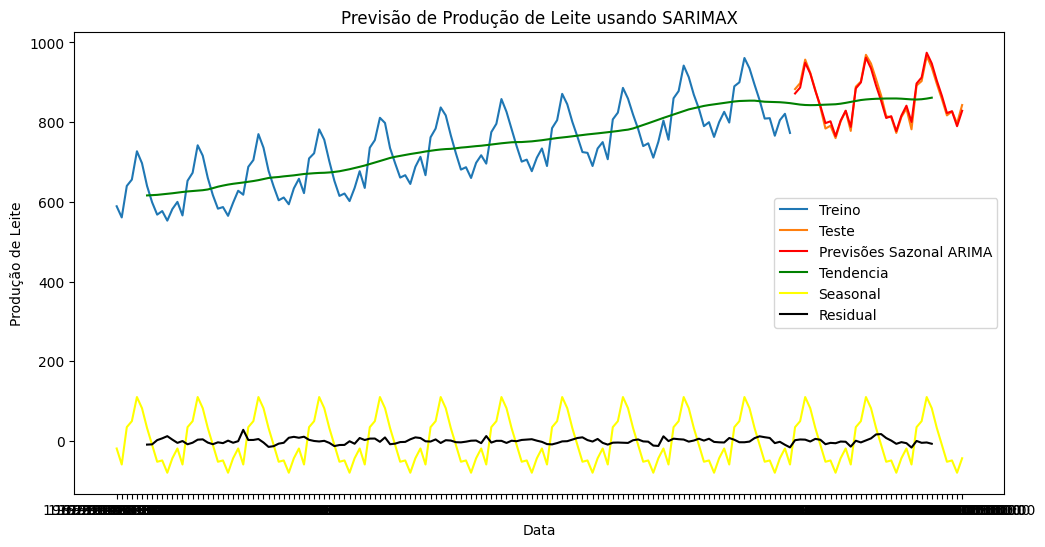

In [15]:
# Visualizar os resultados
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train['Date'], train['Monthly milk production / pounds per cow'], label='Treino')
plt.plot(test['Date'], test['Monthly milk production / pounds per cow'], label='Teste')
plt.plot(test['Date'], predictions, label='Previsões Sazonal ARIMA', color='red')
plt.plot(pd_trend.index, pd_trend.Trend, label='Tendencia', color='Green')
plt.plot(pd_seasonal.index, pd_seasonal.Seasonal, label='Seasonal', color='Yellow')
plt.plot(pd_resid.index, pd_resid.Resid, label='Residual', color='Black')
plt.title('Previsão de Produção de Leite usando SARIMAX')
plt.xlabel('Data')
plt.ylabel('Produção de Leite')
plt.legend()
plt.show()

In [16]:
decomp.trend

,trend
Date,
1961-12-31 23:00:00,NaN
1962-01-31 23:00:00,NaN
1962-02-28 23:00:00,NaN
1962-04-01 00:00:00,NaN
1962-05-01 00:00:00,NaN
...,...
1975-08-01 00:00:00,NaN
1975-09-01 00:00:00,NaN
1975-10-01 00:00:00,NaN
